In [1]:
import abc
import json
import sys
from itertools import product

import numba as nb
import numpy as np
import pandas as pd
from scipy.stats import linregress
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import scale

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

## Labels

We create a dataframe, `label_df` that only contains the label positions for each week.

In [2]:
with open(r'C:\Users\Balazs\source\repos\CryptoAnalysis\label_series.json', 'r') as fproc:
    label_series = json.load(fproc)

Unfortunately, the charts consist of a variable number of positions, therefore the missing values are padded with `np.nan`-s. Only the first hundred positions are kept.

In [3]:
label_series = {_k : _v.__add__([np.nan]*max((100 - len(_v)), 0))[:100] for _k, _v in label_series.items()}
label_df = pd.DataFrame(label_series)

#### Number of unique labels

Firstly, we calculate the number of labels for each week.

In [4]:
total_label_counts = pd.value_counts(label_df.values.ravel(), dropna = True)

#### Density

The label density, $\rho_{L}$ is defined as the number of different labels, $N_{L}$ divided by the number of positions, $N_{P}$:

$$
\rho_{L} = \frac{N_{L}}{N_{P}}
$$

Its value is in the $(0, 1]$ interval. The higher it is, the more labels are represented in the chart. It, however, does not reveal how equaly the singles distributed among labels. For example, let us assume there are 20 places and four labels, then $n_{L} = \frac{4}{20} = 0.2$ irrespective of whether one label has 17 positions and the rest one each, or each label has five positions. 

#### Entropy

The label entropy $H_{L}$ is the entropy of the label distribution. It reflects how uniformly the singles are distributed between labels. The entropy is normalised with its maximum possible value. It, therefore, ranges between 0, where one label owns the whole chart, and 1 where each single is published by a different label.

$$
H_{L} = \frac{\sum\limits_{l=1}^{N_{L}} - p_{l}\log(p_{l})}{\log(N_{L})}
$$

The _unnormalised_ Entropy is the counterpart of the label density in the sense that it does not carry information on the number of labels. For example, consider the cases two charts of length two and twenty where there are two labels both having equal number of hits (1-1 and 10-10), respectively. The entropy will be $H = -0.5 \cdot \log(0.5) -0.5 \cdot \log(0.5) = 1$. The normalising factor "penalises" the cases where the sample size is large, but the number of labels are low.

#### Diveristy

The diversity of the label distribution, $\lambda_{L}$ is defined as the probability that two randomly chosen singles belong to the same label. We invoke the Gini-Simpson diversity which is defined as

$$
    \lambda_{L} = \sum\limits_{l=1}^{N_{L}} p_{l}\, .
$$

The diversity both sensitive to the uniformity of the distribution and the sample size.

The number of positions and the three measures above are compared below.

In [19]:
label_number = label_df.count(axis = 0)
label_density = label_df.nunique(dropna = True) / label_df.count()
label_entropy = label_df.agg(calc_entropy, axis = 0)
label_diversity = label_df.agg(calc_gini_simpson, axis = 0)

The smoothed functions are also calculated.

In [20]:
window_size = 52
working_df = pd.DataFrame({'density' : label_density.rolling(window_size).mean()[window_size:],
                          'entropy' : label_entropy.rolling(window_size).mean()[window_size:], 
                          'diversity' : label_diversity.rolling(window_size).mean()[window_size:]})

working_df['time'] = np.arange(len(working_df))

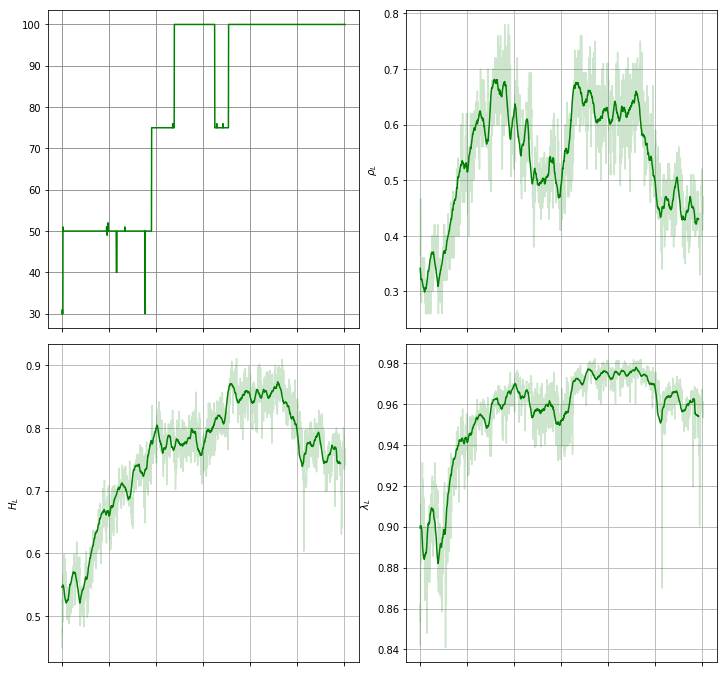

In [23]:
# TO HIDE

fig, axes = plt.subplots(2,2, sharex = True, gridspec_kw = {'hspace' : 0.05, 'wspace' : 0.15})
fig.set_size_inches(12,12)

data = ((label_density, working_df['density']), 
        (label_entropy, working_df['entropy']), 
        (label_diversity, working_df['diversity']))

labels = (r'$\rho_{L}$', r'$H_{L}$', r'$\lambda_{L}$')

label_number.plot(ax = axes[0,0], color = 'green')
axes[0][0].xaxis.grid(color = 'grey')
axes[0][0].yaxis.grid(color = 'grey')

for axis, datum, label in zip(list(axes.flat)[1:], data, labels):
    datum[0].plot(ax = axis, alpha = 0.2, color = 'green')
    datum[1].plot(ax = axis, color = 'green', grid = True)
    axis.set_ylabel(label)

plt.show()

A number of observations can be made. 

* The number of positions does not influence the trend of the entropy.
* The time series can be divided to epochs. Each epoch is a temporal interval when both the density and entropy have consistent behaviour. These epochs in chronological order

1. Initial chaotic period
1. Both the density and entropy increases
1. The density decreases the entropy stalls
1. Both the density and entropy increases
1. Both the density and entropy increases
1. Both the density and entropy stalls

If the entropy is plotted against the density, an interesting layered pattern can be observed. Each elongated blob is suspected to correspond to an epoch. 

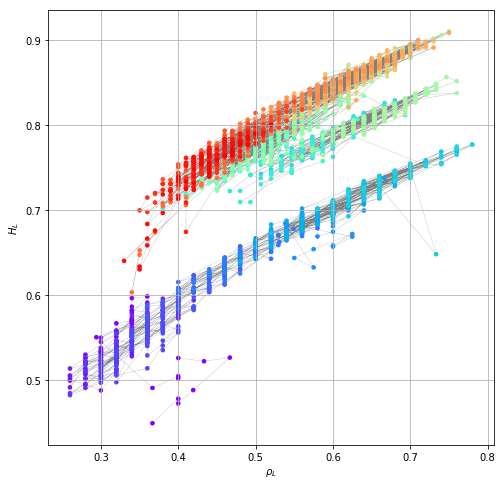

In [24]:
# TO HIDE

fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,8)
ax.plot(label_density, label_entropy, c = 'grey', zorder = -1, lw = 0.2 )
ax.scatter(label_density, label_entropy, 
           c = plt.cm.rainbow(np.arange(label_density.size)/label_density.size), s = 13)
ax.grid(True)
ax.set_xlabel(r'$\rho_{L}$')
ax.set_ylabel(r'$H_{L}$')

plt.show()

The plot separated to decades reveal overlapping regions where the direction of the points are roughly the opposite.

In [25]:
# TO HIDE

dc = map(lambda x: x[0][:3] != x[1][:3], zip(label_density.index[:-1], label_density.index[1:]))
dd = label_density.index[1:][list(dc)]
dd = dd.insert(0, label_density.index[0]).append(pd.Index([label_density.index[-1]]))

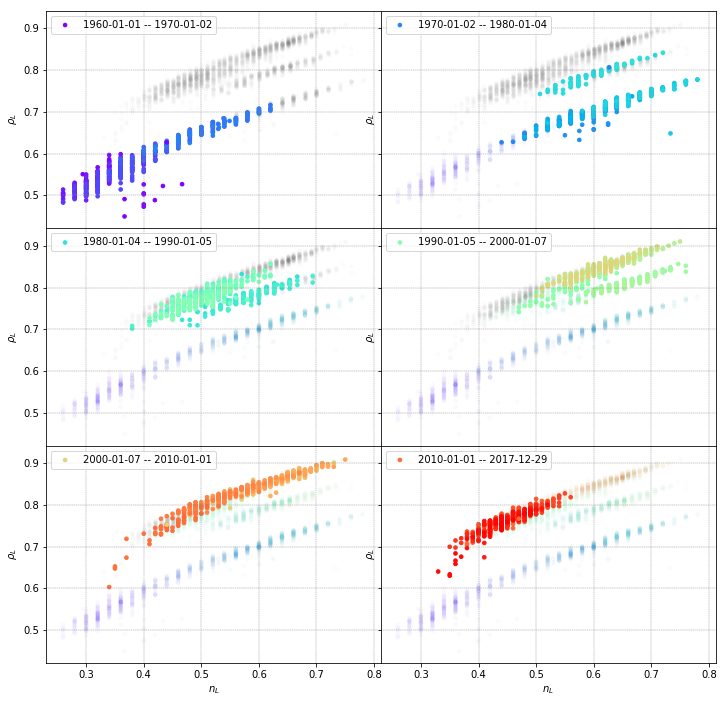

In [26]:
# TO HIDE

fig, axes = plt.subplots(3,2, sharex = True, sharey = True, 
                         gridspec_kw = {'hspace' : 0.0, 'wspace' : 0.0})
fig.set_size_inches(12,12)

for ax, (l_lim, u_lim) in zip(axes.flat, zip(dd[:-1], dd[1:])):
    
    label = str(l_lim) + ' -- ' + str(u_lim)
   
    l_crange = label_entropy.index.get_loc(l_lim)
    u_crange = label_entropy.index.get_loc(u_lim)

    #axis.plot(label_density[l_lim:u_lim], label_entropy[l_lim:u_lim], 
    #          color = 'black', alpha = 0.3)
    
    ax.scatter(label_density[u_lim:], label_entropy[u_lim:], s = 13, c = 'grey', alpha = 0.02)
    
    ax.scatter(label_density[:l_lim:], label_entropy[:l_lim], s = 13, alpha = 0.02,
                c = plt.cm.rainbow(np.arange(l_crange) / label_entropy.size))
    
    ax.scatter(label_density[l_lim:u_lim], label_entropy[l_lim:u_lim], s = 13, label = label,
                 c = plt.cm.rainbow(np.arange(l_crange,u_crange) / label_entropy.size))
    
    ax.legend(loc="upper left")
    ax.xaxis.grid(c = 'grey', linewidth = '0.4', linestyle = '--')
    ax.yaxis.grid(c = 'grey', linewidth = '0.4', linestyle = '--')

    ax.set_xlabel(r'$n_{L}$'); ax.set_ylabel(r'$\rho_{L}$'); 
plt.show()

The time can be used as a third axis to separate the points further. The figures below show progression the raw (left panel) and smoothed (right panel) time series.

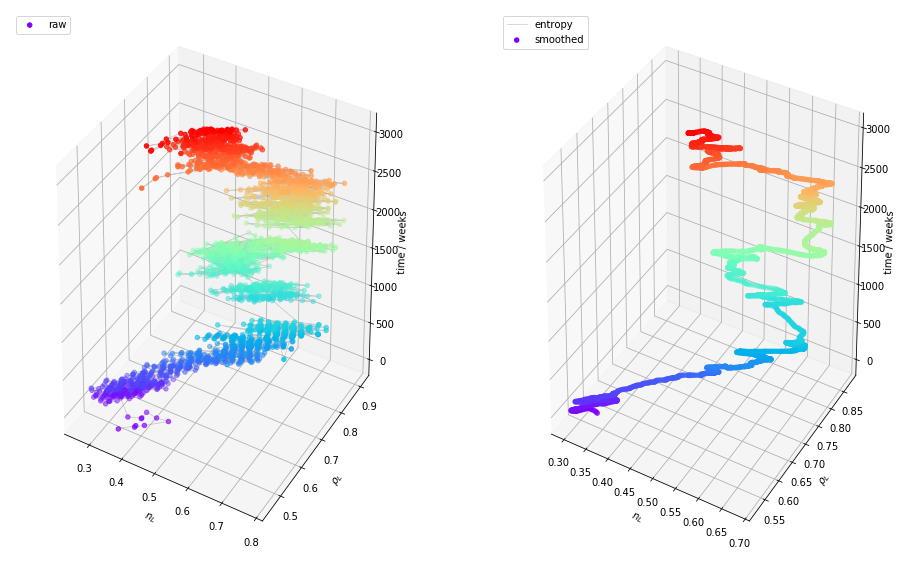

In [29]:
# TO HIDE

fig = plt.figure(figsize=plt.figaspect(0.5))
fig.set_size_inches(16,10)
ax = fig.add_subplot(1, 2, 1, projection='3d')

ax.scatter(label_density, label_entropy, np.arange(label_density.size),
          c = plt.cm.rainbow(np.arange(label_density.size)/label_density.size),
          label = 'raw')

ax.plot(label_density, label_entropy, np.arange(label_density.size), zorder = -1, 
        c = 'grey', alpha = 0.4, linewidth = 0.75)

ax.set_xlabel(r'$n_{L}$'); ax.set_ylabel(r'$\rho_{L}$'); ax.set_zlabel('time / weeks');
ax.legend(loc="upper left")

# smoothed
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(working_df['density'], working_df['entropy'], np.arange(len(working_df)),
           c = plt.cm.rainbow(np.arange(len(working_df))/len(working_df)),
          label = 'smoothed')

ax.plot(working_df['density'], working_df['entropy'], np.arange(len(working_df)),
        zorder = -1, c = 'grey', alpha = 0.4, linewidth = 0.75)

ax.set_xlabel(r'$n_{L}$'); ax.set_ylabel(r'$\rho_{L}$'); ax.set_zlabel('time / weeks');
ax.legend(loc="upper left")

plt.show()

## Finding epochs

We have established there are distinct sections in the time series. It is now time to quantitatively delimit them. 

### Clustering 

It might seem at first a good idea to cluster the data. There are two shortcomings of this procedure.

1. A bog standard clustering algorithm do not take into account the temporal order of the series. There are two remedies:

1.1 Cluster the data in the entropy--density space, then split the clusters based on temporal indices. The main drawback is the possibility of small sets of points of various temporal origin coalescing into a cluster which then cannot be separated.

1.1. Define a temporal distance and cluster the data in the entropy-density-time space.

Note, it is advisable to use _density based_ cluster algorithms, such as DBSCAN, as opposed to _distance based_ methods because of the elongated shape of the blobs.

### Clustering?

Are these epochs really clusters? The smoothed data suggest otherwise. The 'width' of the blobs arise from the fluctuations. These epochs are thus can be better described as noisy lines than clusters. Accordingly, we have to look methods beyond clustering to identify the epochs.

We are going to use segmentation, that is the time series will be divided to non-overlapping subsequent regions. A region is a sequence of time series data, where some property is consistent. The consistency of this property is measured by an appropriately chosen loss function.

## Segmentation

An epoch is a region of the time series where each of the variables has a consistent behaviour, _e.g._ (increasing, increasing), (decreasing, increasing), (constant, increasing) etc. We thus wish to join subqsequent data to minimise a loss function which reflects the uniformity of the trend. Two properties have to be measured:

* The temporal behaviour of the individual series
* The relationship between the two series

### Batch bottom-up segmentation

An obvious way to segment the time series is to fit piecewise polynomials _e.g._ linear, quadratic, on the $(t,\rho), (t,H)$ spaces. We require the segments in each of the two time series to spann between the same limits. This restriction follows from our definition of 'epoch'. 

#### Algorithm

A standard [bottom-up segmentation algorithm]() is invoked. It first divides the entire time series to equal and fixed length segments, then merges them along the minimum cost pattern. An implementation, `BottomUpSegmenter` can be found [here](). Two input parameters are required, the length of the initial segments, `segment_size` and the maximum allowed merge cost or tolerance, `tol`.

#### Cost function

The cost function is the sum of the squared residuals which will be minimised during the fitting. The `calculate_ols_cost` funtion calculates this cost.

#### Fitting parameters

Both parameters influences the outcome of the fit. If the tolerance is small, the segmented time series is expected to be strongly fragmented. Larger tolerances allow for fitting linear functions over longer sections.

Smaller initial segments make the fitting function more flexible, whereas longer ones result in cruder and poorer partitioning of the time series.

A number of tolerances and segment sizes are thus screened. For each of these combinations, the [Akaike information criterion](), AIC is calculated. AIC penalises overfitting by adding twice the number of the parameters to the log-likelihood function. It is implemented in the `calculate_akaike_ic` routine. It is worth noting, it is tacitly assumed the residuals are normally distributed. In that case, the ordinary least squares minimiser maximises the likelihood function.

 As a first step, the smoothed label density and label entropy stacked in a 3D array, `lde_len_sm`. 

In [32]:
working_df['density'] = scale(working_df['density'])
working_df['entropy'] = scale(working_df['entropy'])
working_df['diversity'] = scale(working_df['diversity'])

In [ ]:
pgrid = ParameterGrid({'segment_size' : [10, 20, 50, 100, 200], 
                       'tol' : [0.1, 1.0, 10., 50, 100.0]})

results = []
for params in pgrid:
    segmenter = BottomUp(func = calculate_ols_cost, func_kwargs = {'degree' : 1}, **params)
    segmenter.fit(lde_len_sm)
    results.append(segmenter.get_parameters())

bottomup_results_df = pd.DataFrame(results)
bottomup_results_df.columns = pd.MultiIndex.from_product([['OLS'], bottomup_results_df.columns]) 
bottomup_results_df.head(3)

In [ ]:
# TO HIDE

c2 = ('#1f2605', '#1f6521', '#53800f', '#a4a71e', '#d6ce15', '#f2e105')
# colors from https://blog.visme.co/website-color-schemes/#33
fig, axes = plt.subplots(3, 1, sharex = True)
fig.set_size_inches(6,10)
colors = c2# ('#46211A', '#693D3D', '#BA5536', '#A43820', '#A02410', '#BB5000')
sns.barplot(x = "segment_size", y = "AIC", hue = "tol", data = bottomup_results_df['OLS'],
           palette = colors, ax = axes[0])

sns.barplot(x = "segment_size", y = "LLF", hue = "tol", data = bottomup_results_df['OLS'],
           palette = colors, ax = axes[1])

sns.barplot(x = "segment_size", y = "n_segments", hue = "tol", data = bottomup_results_df['OLS'],
           palette = colors, ax = axes[2])
plt.show()

The lofasz lofasz lofasz lofasz.

In [ ]:
segsize_sel = (bottomup_results_df['OLS']['segment_size'] == ss for ss in [10, 50, 200])
tol_sel = (bottomup_results_df['OLS']['tol'] == tol for tol in [0.1, 10.0, 100.0])

segmentations = (bottomup_results_df['OLS'].loc[x1 & x2, ['segment_indices', 'tol', 'segment_size']]
                    for (x1, x2) in product(segsize_sel, tol_sel))

In [ ]:
fig, axes = plt.subplots(3, 3, sharex = True, sharey = True, gridspec_kw = {'hspace' : 0.02, 'wspace' : 0.02})   
fig.set_size_inches(15,15)
for ax, segmentation in zip(axes.flat, segmentations):
    
    segments = segmentation['segment_indices'].values[0]
    rs, rc, rr = reconstruct_ols_series(lde_len_sm, segments)
    
    ax.plot(lde_len_sm[:,0], lde_len_sm[:,1], c = 'yellowgreen', label = r'$\rho_{l}$')
    ax.plot(lde_len_sm[:,0], lde_len_sm[:,2], c = 'cornflowerblue', label = r'$H_{l}$')
    
    ax.plot(rs[:,0], rs[:,1], c = 'green', label = r'$\rho_{l}$(fit)')
    ax.plot(rs[:,0], rs[:,2], c = 'blue', label = r'$H_{l}$(fit)')
    ax.grid(True)
    title_ = "segment size: {0}, tol: {1}".format(segmentation['segment_size'].values[0], segmentation['tol'].values[0])
    ax.set_title(title_)
    
plt.show()

* all the same
* discontinuity
* small step, large tolerance
* separate

In [ ]:
pgrid = ParameterGrid({'segment_size' : [10, 20, 50, 100, 200], 
                       'tol' : [0.1, 1.0, 10., 50, 100.0]})

results = []
for params in pgrid:
    segmenter = BottomUp(func = calculate_interpolation_cost, **params)
    segmenter.fit(lde_len_sm)
    results.append(segmenter.get_parameters())

bottomup_results_df_ = pd.DataFrame(results)
bottomup_results_df_.columns = pd.MultiIndex.from_product([['Interpolation'], bottomup_results_df_.columns])
bottomup_results_df = pd.concat([bottomup_results_df, bottomup_results_df_], axis = 1)

In [ ]:
# TO HIDE

colors = ('#1f2605', '#1f6521', '#53800f', '#a4a71e', '#d6ce15', '#f2e105')
fig, axes = plt.subplots(3, 1, sharex = True)
fig.set_size_inches(6,10)

sns.barplot(x = "segment_size", y = "AIC", hue = "tol", data = bottomup_results_df['Interpolation'],
           palette = colors, ax = axes[0])

sns.barplot(x = "segment_size", y = "LLF", hue = "tol", data = bottomup_results_df['Interpolation'],
           palette = colors, ax = axes[1])

sns.barplot(x = "segment_size", y = "n_segments", hue = "tol", data = bottomup_results_df['Interpolation'],
           palette = colors, ax = axes[2])
plt.show()

The lofasz lofasz lofasz lofasz.

In [ ]:
# TO HIDE

segsize_sel = (bottomup_results_df['Interpolation']['segment_size'] == ss for ss in [10, 50, 200])
tol_sel = (bottomup_results_df['Interpolation']['tol'] == tol for tol in [0.1, 10.0, 100.0])

segmentations = (bottomup_results_df['Interpolation'].loc[x1 & x2, ['segment_indices', 'tol', 'segment_size']]
                    for (x1, x2) in product(segsize_sel, tol_sel))

In [ ]:
# TO HIDE

fig, axes = plt.subplots(3, 3, sharex = True, sharey = True, gridspec_kw = {'hspace' : 0.02, 'wspace' : 0.02})   
fig.set_size_inches(15,15)
for ax, segmentation in zip(axes.flat, segmentations):
    
    segments = segmentation['segment_indices'].values[0]
    rs = reconstruct_interpolation_series(lde_len_sm, segments)
    
    ax.plot(lde_len_sm[:,0], lde_len_sm[:,1], c = 'yellowgreen', label = r'$\rho_{l}$')
    ax.plot(lde_len_sm[:,0], lde_len_sm[:,2], c = 'cornflowerblue', label = r'$H_{l}$')
    
    ax.plot(rs[:,0], rs[:,1], c = 'green', label = r'$\rho_{l}$(fit)')
    ax.plot(rs[:,0], rs[:,2], c = 'blue', label = r'$H_{l}$(fit)')
    ax.grid(True)
    title_ = "segment size: {0}, tol: {1}".format(segmentation['segment_size'].values[0], segmentation['tol'].values[0])
    ax.set_title(title_)
    
plt.show()

### To-down segmentation

In [ ]:
tols = [0.1, 1, 10, 50, 100, 500]
results = []

for tol in tols:

    segmenter = TopDownSegmenter(func = calculate_ols_cost, func_kwargs = {'degree' : 1}, **{'tol' : tol})
    segmenter.fit(lde_len_sm)
    results.append(segmenter.get_parameters())

topdown_results_df = pd.DataFrame(results)

In [ ]:
# TO HIDE

fig, axes = plt.subplots(2, 3, sharex = True, sharey = True, gridspec_kw = {'hspace' : 0.02, 'wspace' : 0.02})   
fig.set_size_inches(15,15)
for ax, segmentation in zip(axes.flat, topdown_results_df[['segment_indices', 'tol']].iterrows()):
    
    segments = segmentation[1].values[0]
    rs, rc, rr = reconstruct_ols_series(lde_len_sm, segments)
    
    ax.plot(lde_len_sm[:,0], lde_len_sm[:,1], c = 'yellowgreen', label = r'$\rho_{l}$')
    ax.plot(lde_len_sm[:,0], lde_len_sm[:,2], c = 'cornflowerblue', label = r'$H_{l}$')
    
    ax.plot(rs[:,0], rs[:,1], c = 'green', label = r'$\rho_{l}$(fit)')
    ax.plot(rs[:,0], rs[:,2], c = 'blue', label = r'$H_{l}$(fit)')
    ax.grid(True)
    title_ = "tol: {0}".format(segmentation[1].values[1])
    ax.set_title(title_)
    
plt.show()

#### Two stage reconstruction

In [ ]:
segmentation = bottomup_results_df['OLS'].loc[(bottomup_results_df['OLS']['segment_size'] == 10) & 
                                          (bottomup_results_df['OLS']['tol'] == 0.1)]
segmentation

In [ ]:
series, coefs, reps = reconstruct_ols_series(lde_len_sm, segmentation['segment_indices'].values[0])
coef_series = np.repeat(coefs[..., 1], reps, axis = 0)
coefs[0]

In [ ]:
fig, axes = plt.subplots(1,2)
fig.set_size_inches(12,6)
axes[0].scatter(lde_len_sm[:, 0], coef_series[:,0], marker = '.', color = 'green')
axes[0].scatter(lde_len_sm[:, 0], coef_series[:,1],  marker = '.', color = 'blue')
axes[0].plot(lde_len_sm[:, 0], coef_series[:,0], linewidth = 0.2, color = 'green')
axes[0].plot(lde_len_sm[:, 0], coef_series[:,1], linewidth = 0.2, color = 'blue')
axes[0].grid(True)

#axes[1].scatter(lde_len_sm[:, 0], coef_series[:,1] - coef_series[:,0])
axes[1].plot(lde_len_sm[:, 0], np.sign(coef_series[:,1] * coef_series[:,0]), linewidth = 2, color = 'blue')
axes[1].grid(True)
plt.show()

In [ ]:
series = np.hstack([coefs[...,1], reps[:,None]])

In [ ]:
for tol in [10.0, 20.0, 2000.0]:
    segmenter = TopDownSegmenter(func = lofasz, tol = tol)
    segmenter.fit(series)

In [ ]:
# TO HIDE

label = np.repeat(segmenter.labels, reps)
colors_g = np.where(label % 2, 'green', 'yellowgreen')
colors_b = np.where(label % 2, 'blue', 'cornflowerblue')

fig, axes = plt.subplots(1,2)
fig.set_size_inches(12,6)

axes[0].scatter(lde_len_sm[:, 0], coef_series[:,0], marker = '.', color = colors_g)
axes[0].scatter(lde_len_sm[:, 0], coef_series[:,1],  marker = '.', color = colors_b)
axes[0].plot(lde_len_sm[:, 0], coef_series[:,0], linewidth = 0.2, color = 'grey')
axes[0].plot(lde_len_sm[:, 0], coef_series[:,1], linewidth = 0.2, color = 'grey')
axes[0].grid(True)

axes[1].scatter(lde_len_sm[:,0], lde_len_sm[:,1], marker = '.', c = colors_g, label = r'$\rho_{l}$')
axes[1].scatter(lde_len_sm[:,0], lde_len_sm[:,2], marker = '.', c = colors_b, label = r'$H_{l}$')

plt.show()

### Correlation space

In [ ]:
working_df['corr_time_dens'] = working_df['time'].rolling(52).corr(other = working_df['density'])
working_df['corr_time_ent'] = working_df['time'].rolling(52).corr(other = working_df['entropy'])
working_df['corr_dens_ent'] = working_df['density'].rolling(52).corr(other = working_df['entropy'])

In [ ]:
# TO HIDE

fig, axes = plt.subplots(1, 2, sharey = True, gridspec_kw = {'hspace' : 0.01, 'wspace' : 0.01})
fig.set_size_inches(12, 6)

axes[0].plot(working_df['time'], working_df['corr_time_dens'], c = 'navy')
axes[0].plot(working_df['time'], working_df['corr_time_ent'], c = 'green')

axes[0].fill_between(working_df['time'], working_df['corr_time_ent'], working_df['corr_time_dens'], 
                where = working_df['corr_time_dens'] >= working_df['corr_time_ent'], color = 'navy', alpha = 0.2)

axes[0].fill_between(working_df['time'], working_df['corr_time_ent'], working_df['corr_time_dens'], 
                where = working_df['corr_time_dens'] < working_df['corr_time_ent'],  color = 'green', alpha = 0.2)
axes[0].grid(True)

axes[1].plot(working_df['time'], working_df['corr_dens_ent'], color = 'red')
axes[1].grid(True)
plt.show()

In [ ]:
graph = sns.jointplot(working_df['corr_time_dens'], working_df['corr_time_ent'], kind = 'hex', alpha = 1.0)
graph.x =  working_df['corr_time_dens']
graph.y =  working_df['corr_time_ent']
graph.plot_joint(plt.scatter, c = 'blue', alpha = 0.2)
graph.plot_joint(plt.plot, c = 'grey', alpha = 0.2)
plt.show()

In [ ]:
def binner(x):
    
    if x >= 0.50:
        return 4
    elif 0.75 > x >= 0.50:
        return 3
    elif 0.50 > x >= -0.50:
        return 2
    elif -0.50 > x >= -0.75:
        return 1
    else:
        return 0

In [ ]:
working_df['corr_time_dens_q'] = working_df['corr_time_dens'].apply(lambda x: binner(x))
working_df['corr_time_ent_q'] = working_df['corr_time_ent'].apply(lambda x: binner(x))

In [ ]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12,8)

ax.scatter(working_df['time'], working_df['corr_time_dens_q'], c = 'navy', alpha = 0.3)
ax.scatter(working_df['time'], working_df['corr_time_ent_q'], c = 'green', zorder = -1)

ax.grid(True)
plt.show()

In [ ]:
working_df['unit'] = 1
series = working_df[['corr_time_dens_q', 'corr_time_ent_q', 'unit']].values[52:].astype(np.float)

In [ ]:
calculate_average_distance(series)
print(series.shape)

In [ ]:
for tol in [1]:
    segmenter = TopDownSegmenter(func = calculate_average_distance, tol = tol)
    segmenter.fit(series)

In [ ]:
graph = sns.jointplot(working_df['corr_time_dens_q'], working_df['corr_time_ent_q'], kind = 'hex', alpha = 1.0)
graph.x =  working_df['corr_time_dens_q']
graph.y =  working_df['corr_time_ent_q']
plt.show()

### Miscellaneous functions

In [ ]:
def calc_entropy(vals):
    """
    Calculates the entropy of a sample. The entropy is based on the frequency of distinct elements in the array.
    Parameters:
        vals (np.ndarray) : 1D numpy array
    Returns:
        entropy (float) : the normalised entropy 
    """
    idcs = ~pd.isnull(vals)
    values_, counts = np.unique(vals[idcs], return_counts = True)
    n_count = np.sum(counts)
        
    if n_count == 0:
        return 0.0

    prob = counts * 1.0 / n_count

    entropy = - np.dot(prob, np.log(prob))
    
    # normalise to maximum entropy
    max_entropy =  np.log(vals.size)
    
    entropy /= max_entropy
    
    return entropy

In [ ]:
def calc_gini_simpson(vals):
    """
    Calculates the Gini--Simpson diversity of a sample.
    Parameters:
        vals (np.ndarray) : sample
    Returns : 
        gini_simpson (float) : the Gini--simson diversity
    """
    idcs = ~pd.isnull(vals)
    values_, counts = np.unique(vals[idcs], return_counts = True)
    n_count = np.sum(counts)
        
    if n_count == 0:
        return 0.0

    prob = counts * 1.0 / n_count

    gini_simpson = 1.0 - np.dot(prob, prob)
    
    return gini_simpson    

In [ ]:
def calculate_pattern_cc_cost(pattern, f, block_indices):
    """
    Calculates the correlation coefficient in a section of a time series
    Parameters:
        pattern ((int, int)) : the position and length of section
        f (np.ndarray) : time series
        block_indices (npndarray of int) : the delimiting indices of the blocks
    Returns:
        cost (float) : the correlation coefficient weighted by the length of the section relative to
        the length of the entire time series
    """
    
    pos, length = pattern
    
    i_start = block_indices[pos, 0]
    i_end = block_indices[pos + length - 1, 1]

    cc = np.corrcoef(f[:,i_start:i_end], rowvar = True)[0,1]
    cost = np.abs(cc)
    
    pattern_length = i_end - i_start
    total_length = block_indices[-1,1] - block_indices[0,0]
    weigth = pattern_length  * 1.0 / total_length
    
    cost *= weigth 
    
    return cost

### Functions for model selection

In [ ]:
def calculate_ols_cost(X, degree = 1):
    """
    Calculates the sum of squared residuals (chi-square) of a polynomial fit.
    Parameters:
        X (np.ndarray)[n_observations, n_attributes] : the time series. 
        The first column is the time. The response variables are stored in the subsequent columns.
        degree (int) : degree of the polynomial. Default 1.
    
    Returns:
        chi2 (float) : sum of the squared residuals 
    """
    coef, resid, rank, sv, rcond = np.polyfit(X[:, 0], X[:, 1:], degree, full = True)
        
    # add for all time series
    residuals2 = resid.sum()
    
    return residuals2 

In [ ]:
def lin_interpol(X):
    
    x =  (X[:, 0] - X[0, 0]) / (X[-1, 0] - X[0, 0]) # 0 --> 1 
    y_delta = X[-1, 1:] - X[0, 1:]
    y_fit = np.outer(x, y_delta) + X[0, 1:]
    
    return y_fit

In [ ]:
@nb.jit(nopython = True)
def calculate_average_distance(x):
    
    npoints = x.shape[0]
    if npoints == 1:
        return 0.0
    
    wsum = 0.0
    dsum = 0.0
    
    for i in range(npoints):
        for j in range(i + 1, npoints):
            w = x[i, -1] * x[j, -1]
            diff = x[i, :-1] - x[j, :-1]
            v = 0.0
            for y in diff:
                v += y * y
            dsum += np.sqrt(v) * w
            wsum += w
            
    dsum /= wsum
    
    return dsum

a = np.array([[1 ,2, 3], [1, 8, 5]], dtype = np.float32)
_ = calculate_average_distance(a)

In [ ]:
def calculate_interpolation_cost(X):
    """
    Calculates the sum of squared residuals (chi-square) of a polynomial fit.
    Parameters:
        X (np.ndarray)[n_observations, n_attributes] : the time series. 
        The first column is the time. The response variables are stored in the subsequent columns.
        degree (int) : degree of the polynomial. Default 1.
    
    Returns:
        chi2 (float) : sum of the squared residuals 
    """
    y_fit = lin_interpol(X)
    diff = y_fit - X[:,1:]
    residuals2 = np.sqrt(np.sum(diff * diff))
    
    return residuals2 

In [ ]:
def reconstruct_ols_series(X, segments):
    """
    Parameters:
        X (np.ndarray) : time series
        segments (np.ndarray)[n_segments, 2] : segment start and end indices
    Returns:
        series_rec, coef_rec
    """
    
    coefs = np.zeros((segments.shape[0], X.shape[1] - 1, 2), dtype = np.float)    
    
    for idx, (i_start, i_end) in enumerate(segments):
        coef, resid, rank, sv, rcond = np.polyfit(X[i_start:i_end, 0], X[i_start : i_end, 1:], 1, full = True)
        coefs[idx] = coef.T
    
    coef_repetitions = np.ravel(segments[:, 1] - segments[:, 0])
    coef_rec = coefs
    
    coefs = np.repeat(coefs, coef_repetitions, axis = 0)
    X_rec = coefs[..., 0] * X[:, 0][:, None] + coefs[...,1] 
    X_rec = np.hstack([X[:, 0, None], X_rec])
    
    return X_rec, coef_rec, coef_repetitions

In [ ]:
def reconstruct_interpolation_series(X, segments):
    
    X_rec = np.zeros_like(X)
    for il, iu in segments:
        X_rec[il:iu, 1:] = lin_interpol(X[il:iu])
    
    X_rec[:,0] = X[:,0]
    
    return X_rec

In [ ]:
def calculate_loglikelihood_function(n_residuals, residuals2):
    """
    Calculates the likelihood function of an OLS fit.
    Parameters:
        n_residuals (int) : number of residuals (length of fitted function)
        residuals2 (float) : sum of the squared residuals
    Returns:
        llf (int) : the log likelihood function (w/o) the constant factor
    """
    
    llf = - 0.50 * n_residuals * np.log(residuals2 / n_residuals)
    
    return llf

In [ ]:
def calculate_akaike_ic(n_residuals, residuals2, n_parameters):
    """
    Calculates the Akaike information criterion
    Parameters:
        n_residuals (int) : number of the residuals
        residuals2 (float) : sum of the squared residuals
        n_parameters (int) : number of parameters of the model
    Returns:
        aic (float) : Akaike information criterion
    """
    
    llf = calculate_loglikelihood_function(n_residuals, residuals2)
    aic = np.log(n_residuals) * n_parameters - 2 * llf
    
    return aic

In [ ]:
class SegmenterBaseClass(object):
    
    @property
    def aic(self):
        return self._aic
    
    @property
    def cost(self):
        return self._cost
    
    @property
    def costs(self):
        return self._costs
    
    @property
    def labels(self):
        return self._labels
    
    @property
    def llf(self):
        self._llf
    
    @property
    def n_parameters(self):
        self._n_parameters
    
    @property
    def n_residuals(self):
        return self._n_residuals
    
    @property
    def n_segments(self):
        return self._n_segments
    
    @property
    def segments(self):
        return self._segments
    
    @property
    def segment_indices(self):
        return self._segment_indices
    
    @property
    def tol(self):
        return self._tol
    
    def __init__(self,
                n_parameters = None,
                n_residuals = None,
                tol = None,
                func = None, 
                func_args = [], 
                func_kwargs = {}):
        
        self._named_parameters = {}
        
        # input params
        if not callable(func):
            raise TypeError("func must be callable")
        
        self._func = func
        self._func_args = func_args
        self._func_kwargs = func_kwargs
        
        if tol is None:
            raise ValueError("tol must be specified")
        self._tol = tol
        self._named_parameters.update({'tol' : self._tol})
        
        # the accurate value of these parameters depend on the fitting data
        # and the results of the fit
        self._n_parameters = n_parameters
        self._n_residuals = n_residuals
        
        # results
        self._cost = None
        self._costs = None
        self._labels = None
        self._n_segments = None
        self._segments = []
        self._segment_indices = None
    
    @abc.abstractmethod
    def fit(self, X):
        pass
    
    def fit_predict(self, X):
        return self.fit(X)._labels
                
    def _assign_labels(self, X):
        """
        Assigns a label to each datum in the time series based to which segment it belongs.
        Parameters:
            X (np.ndarray) : time series to fit
        Sets:
            self._labels (np.ndarray) : array of labels {0,0,...0, 1,..., self._n_segments, ..., self._n_segments}
        """
        
        self._labels = np.zeros(X.shape[0], dtype = np.int)
        
        for idx, (idx_start, idx_end) in enumerate(self._segment_indices):
            self._labels[idx_start : idx_end] = idx
        
        self._labels[-1] = idx
    
    def get_parameters(self):
        params = {'n_parameters' : self._n_parameters,
                  'n_residuals' : self.n_residuals,
                  'n_segments' : self.n_segments,
                  'segment_indices' : self._segment_indices,
                  'cost' : self.cost,
                  'LLF' : self._llf,
                  'AIC' : self.aic}
        
        params.update(self._func_kwargs)
        params.update(self._named_parameters)
        
        return params
    
    
    def _finalise(self, X):
        """
        Performs misc tasks to gather information on the fit
        """
        self._set_segment_indices()
        self._set_n_segments()
        self._set_n_parameters(X)
        self._assign_labels(X)
        self._set_n_residuals(X)
        self._set_final_costs()
        self._calculate_goodness_of_fit(X)

    def _set_final_costs(self):
        """
        Creates a numpy array of the segment costs.
        Calculates the grand total of costs.
        """
        
        self._costs = np.array([x['cost'] for x in self._segments])
        self._cost = np.sum(self._costs)
        
    def _calculate_goodness_of_fit(self, X):
        """
        Calculates the Akaike information criterion.
        Calculates the log likelihood function.
        """
        self._aic = calculate_akaike_ic(self._n_residuals, self.cost, self._n_parameters)
        self._llf = calculate_loglikelihood_function(self._n_residuals, self._cost)
    
    def _set_n_parameters(self, X):
        """
        Sets the number of final parameters:
        Default it is the number of time series times the number of segments
        If self._n_parameters is not None, it is interpreted as a multiplicative factor applied to the above number.
        
        """
        if self._n_parameters is None:
            self._n_parameters = self._n_segments * (X.shape[1]  - 1)
        else:
            self._n_paramters = self._n_segments * (X.shape[1]  - 1) * self._n_parameters
    
    def _set_n_segments(self):
        """
        Counts the segments in the time series.
        """
        self._n_segments = self._segment_indices.shape[0]
    
    def _set_n_residuals(self, X):
        """
        Counts the the individual data for all time series
        """
        if self._n_residuals is None:
            self._n_residuals = X.shape[0] * (X.shape[1] - 1)
            
    
    def _set_segment_indices(self):
        """
        Sets the indices wiwh delimit the segments.
        Sets:
            self._segment_indices (np.ndarray)[self._n_segments, 2]
        """
        self._segment_indices = np.array([[x['idx_start'], x['idx_end']] for x in self._segments], dtype = np.int)
        

In [ ]:
class BottomUp(SegmenterBaseClass):
    
        
    @property
    def segment_size(self):
        return self._segment_size
    
    @property
    def segment_indices(self):
        return self._segment_indices
    
    def __init__(self, segment_size = None, 
                tol = None,
                func = None, 
                func_args = [], 
                func_kwargs = {}):

        super().__init__(tol = tol, 
                         func = func, 
                         func_args = func_args, 
                         func_kwargs = func_kwargs)
        
        if not isinstance(segment_size, int):
            raise TypeError("segment_size must be integer. Got: {0}".format(segment_size))
            
        if segment_size < 1:
            raise ValueError("segment_size must be positive. Got: {0}".format(segment_size))
        self._segment_size = segment_size  
        self._named_parameters.update({'segment_size' : self._segment_size})
        
    def fit(self, X):
        
        self._initialise_segments(X)
        
        merges = []
        
        for idx in range(len(self._segments) - 1):
            idx_start = self._segments[idx]['idx_start']
            idx_end = self._segments[idx + 1]['idx_end']
            
            cost = self._func(X[idx_start : idx_end], 
                              *self._func_args, **self._func_kwargs)
            
            merges.append({'cost' : cost,
                           'idx_start' : idx_start,
                           'idx_end' : idx_end})
            
        # loop until all segments are merged to one in case of cheap merges
        while len(merges) > 1:
            
            # find cheapest among merge candidates
            merge = min(merges, key = lambda m: m['cost'])
            
            # stop if lowest cost higher than treshold
            if merge['cost'] > self._tol:
                break
            
            idx = merges.index(merge)
            
            # merge to new segment and remove old one
            self._segments[idx] = dict(merge.items())
            del self._segments[idx + 1]
            
            if idx < len(self._segments) - 1:
                merges[idx].update({'idx_end' : self._segments[idx + 1]['idx_end']} )
                merges[idx]['cost'] = self._func(X[merges[idx]['idx_start'] : merges[idx]['idx_end']], 
                                                 *self._func_args, **self._func_kwargs)
                del merges[idx + 1]
                
            else:
                del merges[idx]
                
            if idx > 0:
                merges[idx - 1].update({'idx_end' : self._segments[idx]['idx_end']} )
                merges[idx - 1]['cost'] = self._func(X[merges[idx - 1]['idx_start'] : merges[idx - 1]['idx_end']], 
                                                     *self._func_args, **self._func_kwargs)
         
        # finalise data
        self._finalise(X)
        
        return self
    
    def _initialise_segments(self, X):
        
        segments = []
        lims = list(range(0, X.shape[0], self._segment_size))
        
        if lims[-1] < X.shape[0]:
            lims[-1] = X.shape[0]

        for idx_start, idx_end in list(zip(*([lims[:-1], lims[1:]]))):
            
            cost = self._func(X[idx_start : idx_end], 
                              *self._func_args,
                              **self._func_kwargs)
            
            segments.append({'cost' : cost, 
                           'idx_start' : idx_start, 
                           'idx_end' : idx_end,
                           'old_idx_end' : idx_end})

            self._segments = segments

In [ ]:
class TopDownSegmenter(SegmenterBaseClass):
    
    
    def __init__(self, tol = None,
                 func = None, 
                 func_args = [], 
                 func_kwargs = {}):
    
    
        super().__init__(tol = tol, 
                         func = func, 
                         func_args = func_args, 
                         func_kwargs = func_kwargs)       
        
    def fit(self, X):
        
        lims = (0, X.shape[0])
        self._topDown(X, lims)
        
        # finalise data  
        self._finalise(X)       
        
        return self
        
    def _topDown(self, X, lims):

        idx_start, idx_end = lims
        idx_best = idx_start
        cost_best = cost_left_best = cost_right_best = np.inf # lovely, eh?
        
        # we need something to speed this up
        for idx in range(idx_start + 1, idx_end - 1):

            segment_left = X[idx_start : idx]
            segment_right = X[idx : idx_end]

            cost_left = self._func(segment_left, *self._func_args, **self._func_kwargs)
            cost_right = self._func(segment_right, *self._func_args, **self._func_kwargs)
            cost_current = cost_left + cost_right
            
            if cost_current < cost_best:
                cost_best = cost_current
                cost_left_best = cost_left
                cost_right_best = cost_right
                idx_best = idx
        
        if (cost_left_best > self._tol) and (idx_start < idx_best):
            self._topDown(X, (idx_start, idx_best))
        else:
            self._segments.append({'cost' : cost_left_best, 'idx_start' : idx_start, 'idx_end' : idx_best})
            
        if (cost_right_best > self._tol) and (idx_start < idx_best):
            self._topDown(X, (idx_best, idx_end))
        else:
            self._segments.append({'cost' : cost_right_best, 'idx_start' : idx_best, 'idx_end' : idx_end})
            